# Analytics on the algorithms performance

We provide here a detailed analysis on the runtime performance and efficiency of the different algorithms on the different datasets.

In [40]:
import os
import subprocess
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [41]:
ALGORITHMS_ARG = ["median", "iter-median", "barycenter", "iter-barycenter"]
ALGORITHMS_DIR = ["median", "iterated_median",
                  "barycenter", "iterated_barycenter"]
DATASETS = ["tiny", "medium"]  # "large"]
EXECUTABLE = ["cargo", "run", "--release", "--bin", "ocm-cli", "--"]

Helper functions to run and load the data

In [42]:
def run_analytics():
    """Compute analytics for every algorithm on every dataset"""
    for algo in ALGORITHMS_ARG:
        for dataset in DATASETS:
            print(f"Running analytics for {algo} on {dataset} dataset")

            # Scan files in datasets/<dataset>
            files = os.listdir(f"datasets/{dataset}")

            for file in tqdm(files):
                relative_path = f"datasets/{dataset}/{file}"

                # Run the executable with analytics output on this file
                subprocess.run(
                    EXECUTABLE + ["-a", algo,
                                  relative_path, "-v", "--analytics"],
                    check=True,
                    stdout=subprocess.DEVNULL,
                    stderr=subprocess.DEVNULL,
                )


def read_dataset_metadata():
    """Load the metadata (top count, bot count, edge count) for each dataset file.
    They are stored in a dict indexed by ("dataset", "filename")."""

    dataset_metadata: dict[tuple[str, str], tuple[int, int, int]] = {}

    for dataset in DATASETS:
        files = os.listdir(f"datasets/{dataset}")

        for file in files:
            with open(f"datasets/{dataset}/{file}", "r", encoding="utf-8") as f:
                _, _, top, bot, edges = f.readline().split()
                dataset_metadata[(dataset, file)] = (
                    int(top), int(bot), int(edges))

    return dataset_metadata


def read_dataset_analytics():
    """Load the dataset analytics output (crossings before, crossings after, nanos runtime)
    available for each algorithm and dataset. They are stored in a dict indexed by
    ("algorithm", "dataset", "filename")."""

    analytics_data: dict[tuple[str, str, str], tuple[int, int, int]] = {}

    available_algos = os.listdir("analytics")
    for algo in available_algos:
        available_datasets = os.listdir(f"analytics/{algo}")
        for dataset in available_datasets:
            files = os.listdir(f"analytics/{algo}/{dataset}")
            for file in files:
                with open(
                    f"analytics/{algo}/{dataset}/{file}", "r", encoding="utf-8"
                ) as f:
                    before, after, runtime, *_ = f.readlines()
                    analytics_data[(algo, dataset, file[:-4])] = (
                        int(before),
                        int(after),
                        int(runtime),
                    )

    return analytics_data

In [43]:
analytics_data = read_dataset_analytics()
dataset_metadata = read_dataset_metadata()

## Runtime Complexity

We print here the runtime complexity of every algorithm, in relation to the total number of nodes and the total number of edges comparatively. Note that we omit iterated methods because of interference from the crossing count algorithm.

### Node Count Runtime Complexity

In [44]:
# For each algorithm, store (node_count, runtime nanos) point lists for plotting
SIMPLE_ALGOS = ["median", "barycenter"]
algos_points = {algo: ([], []) for algo in SIMPLE_ALGOS}

for (algo, dataset, file), (before, after, runtime) in analytics_data.items():
    key = (dataset, file)
    if key not in dataset_metadata or algo not in SIMPLE_ALGOS:
        continue

    top, bot, edges = dataset_metadata[key]
    algos_points[algo][0].append(top + bot)
    algos_points[algo][1].append(runtime)

# Sort the coordinates by node count
for algo, (x, y) in algos_points.items():
    x, y = zip(*sorted(zip(x, y)))
    algos_points[algo] = (x, y)

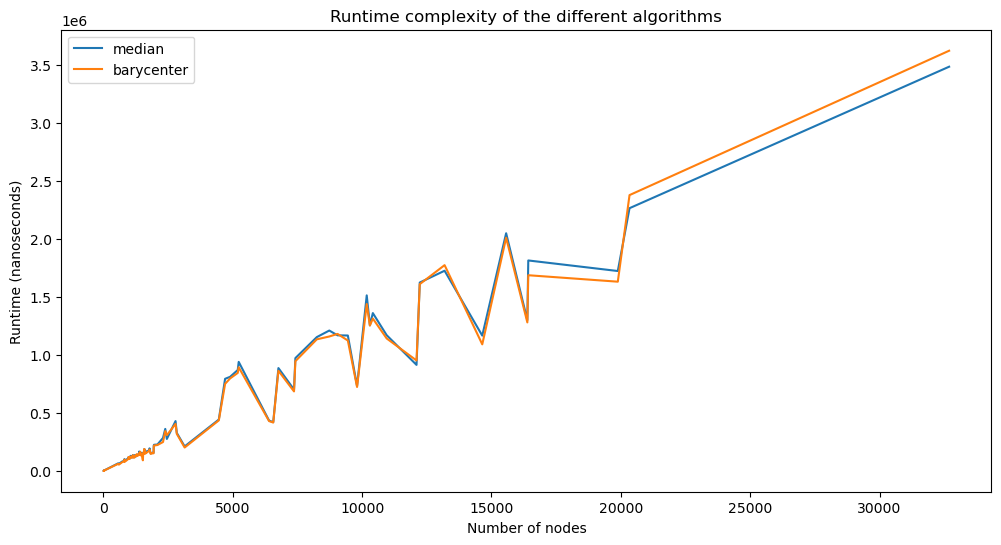

In [45]:
# Plot all runtime complexities on the same graph
plt.figure(figsize=(12, 6))

for algo, (x, y) in algos_points.items():
    plt.plot(x, y, label=algo)

plt.xlabel("Number of nodes")
plt.ylabel("Runtime (nanoseconds)")

plt.legend()
plt.title("Runtime complexity of the different algorithms")
plt.show()

As expected, the runtime complexity of the algorithms is linear in the number of nodes, and quite similar. Our way of computing the median has complexity `O(n log n)` because of the sorting step, but it does not show here.

### Edge Count Runtime Complexity

In [46]:
# For each algorithm, store (node_count, runtime nanos) point lists for plotting
SIMPLE_ALGOS = ["median", "barycenter"]
algos_points = {algo: ([], []) for algo in SIMPLE_ALGOS}

for (algo, dataset, file), (before, after, runtime) in analytics_data.items():
    key = (dataset, file)
    if key not in dataset_metadata or algo not in SIMPLE_ALGOS:
        continue

    top, bot, edges = dataset_metadata[key]
    algos_points[algo][0].append(edges)
    algos_points[algo][1].append(runtime)

# Sort the coordinates by node count
for algo, (x, y) in algos_points.items():
    x, y = zip(*sorted(zip(x, y)))
    algos_points[algo] = (x, y)

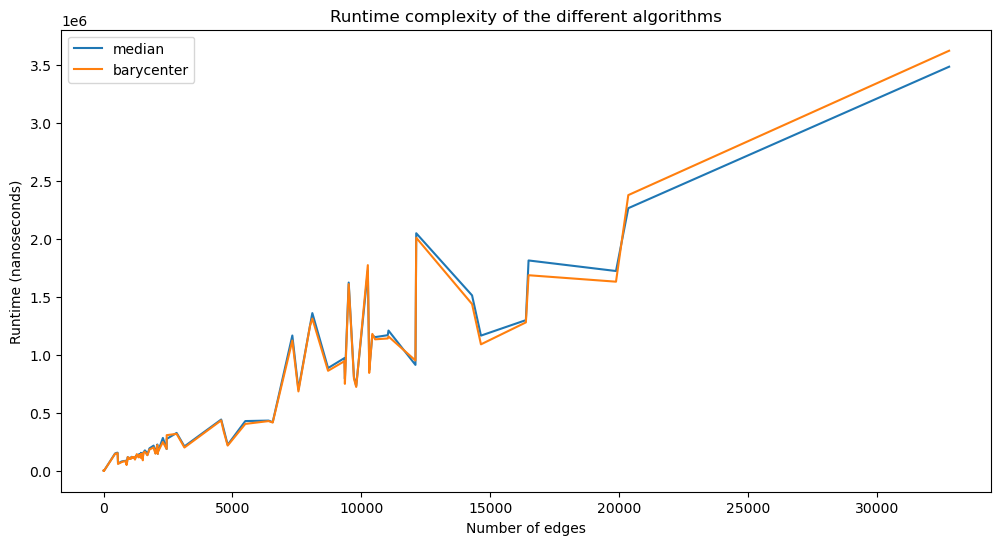

In [47]:
# Plot all runtime complexities on the same graph
plt.figure(figsize=(12, 6))

for algo, (x, y) in algos_points.items():
    plt.plot(x, y, label=algo)

plt.xlabel("Number of edges")
plt.ylabel("Runtime (nanoseconds)")

plt.legend()
plt.title("Runtime complexity of the different algorithms")
plt.show()

We get similar results with the runtime complexity relative to the edge count.

## Performance

We then compare the result efficiency of the different algorithms in terms of the number of crossings they were able to remove. We use the following score:

$$
\text{score} = \frac{\text{initial\_crossings} - \text{final\_crossings}}{\text{initial\_crossings}}
$$

In [48]:
# Initialize the scores dict
scores = {algo: [] for algo in ALGORITHMS_DIR}
crossings = {algo: [] for algo in ALGORITHMS_DIR}
initial_crossings: list[int] = []

# Add every score from the analytics
for (algo, dataset, file), (before, after, runtime) in analytics_data.items():

    score = (before - after) / (before)
    scores[algo].append(score)
    crossings[algo].append(after)

    if algo == "median":
        # Only count initial crossings once
        initial_crossings.append(before)

In [49]:
# Build a pandas DataFrame to summarize the scores mean and std
means = {algo: np.mean(scores) for algo, scores in scores.items()}
stds = {algo: np.std(scores) for algo, scores in scores.items()}

df = pd.DataFrame({"mean": means, "std": stds})
df

,mean,std
median,-0.374050,1.974191
iterated_median,0.043431,0.146482
barycenter,-0.373386,1.964227
iterated_barycenter,0.044829,0.158791


In [50]:
# Compare single iteration barycentric methods with single iteration median methods
# We add 1 in order to avoid division by 0
ratio = (np.array(crossings["median"]) + 1) / \
    (np.array(crossings["barycenter"]) + 1)
print("Mean:", ratio.mean())
print("Std:", ratio.std())

Mean: 1.1788846106145223
Std: 1.3993372063123453


The median method gives results that have 18% more crossings than the barycentric method in average.

In [51]:
# Compare iterated with single, and if the score is worst than default, reset to default. (in order to see the whole imrpovemeents)
iter_crossings = np.array(crossings["iterated_barycenter"]) + 1
init_crossings = np.array(initial_crossings) + 1
bary_crossings = np.array(crossings["barycenter"]) + 1
# Ignore when one run of barycentric is worse than initial
bounded_bary = np.minimum(init_crossings, bary_crossings)

# Compute the improvement ratio
naive_ratio = bary_crossings / iter_crossings
bounded_ratio = bounded_bary / iter_crossings

print("Mean naive:", naive_ratio.mean())
print("Std naive:", naive_ratio.std())
print("Mean bounded:", bounded_ratio.mean())
print("Std bounded:", bounded_ratio.std())

Mean naive: 1.4951496268432702
Std naive: 2.0717983710659325
Mean bounded: 1.0685313490478447
Std bounded: 0.7584429146835082


Naively doing one iteration of the barycentric method can yield up to 50% more crossings than the smarter iterated barycentric method. If we ignore times when the first barycentric method increases crossings, the single iteration barycentric method only yields 6% more crossings in average.

We can see that surprisingly, the median and barycentric algorithms tend to actually increase the amount of crossings in graphs. This often happens with graphs taken from the larger datasets.

Iterated methods take a more intelligent approach, and are able to only keep the best result from the iterations done. They take a significantly higher time to run because they compute the crossings many time, but they are able to remove crossings a lot more consistently.

The results for iterated median and barycentric methods are similar (respectively -4.3% and -4.5% crossings on average).

## Line Sweep Crossing Count Benchmark

We benchmarked the line sweep crossing count algorithm on all datasets.
We will compare the results to different combinations of the node and edge counts.

In [52]:
# Load the data from csv
df = pd.read_csv("crossings_benchmark.csv", header=None)
df.columns = ["node count", "edge count", "exec nanosecs"]

# Remove outliers for better visualization
df = df[
    (df["exec nanosecs"] < 1e11)
    & ((df["exec nanosecs"] > 2e9) | (df["node count"] < 1e4))
]


df.head()

,node count,edge count,exec nanosecs
0,8,4,38784
1,9,8,10831
2,9,8,8296
3,11,10,12734
4,8,6,6382


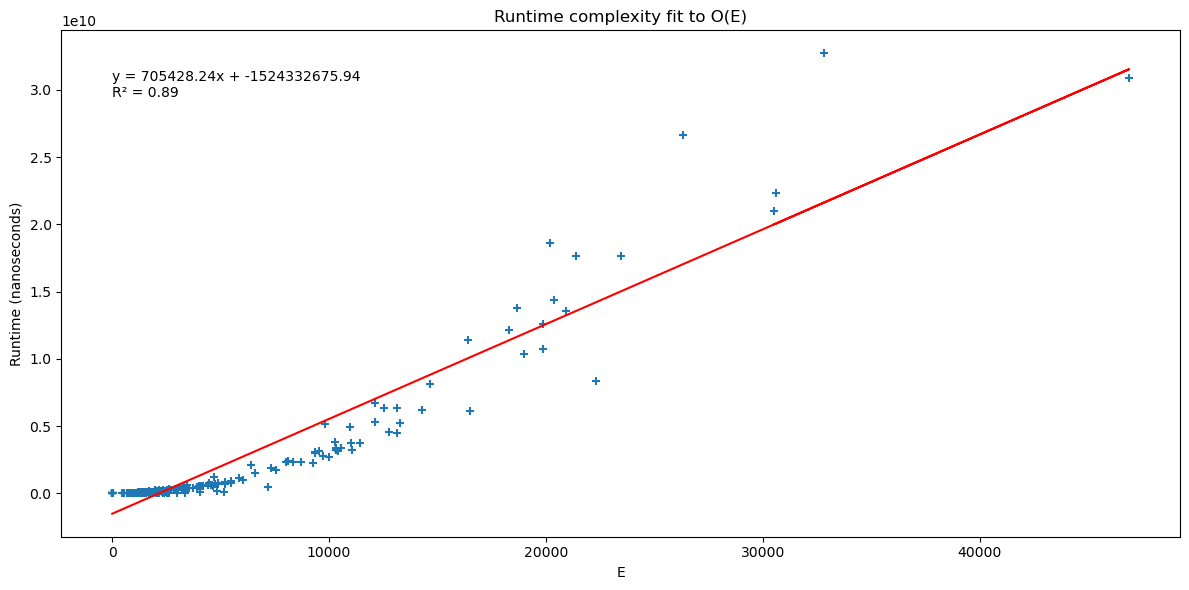

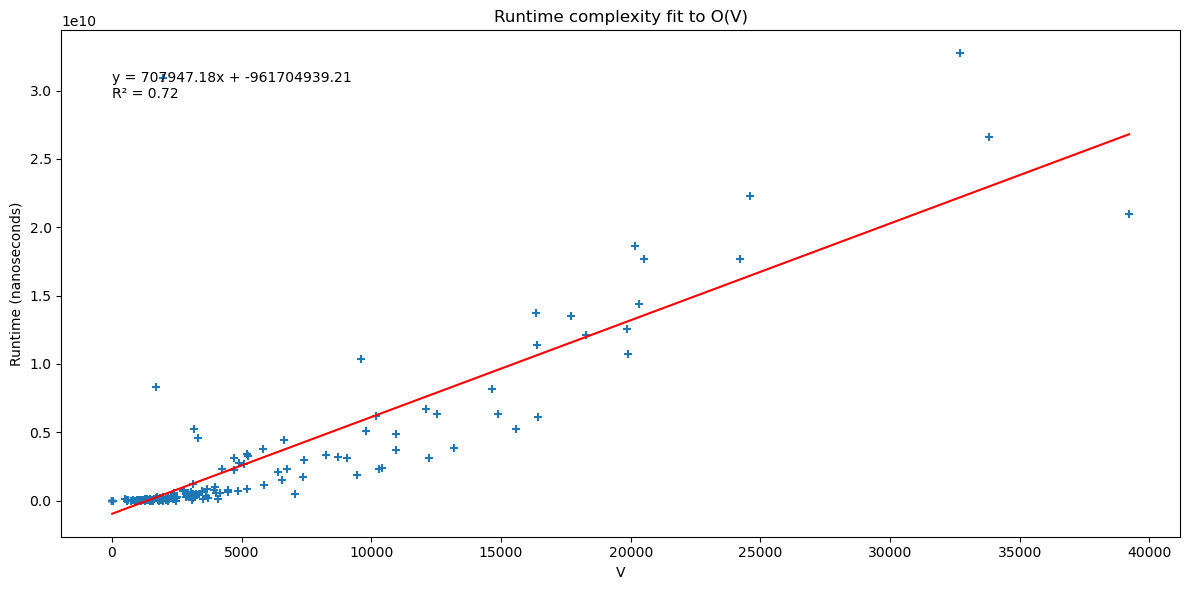

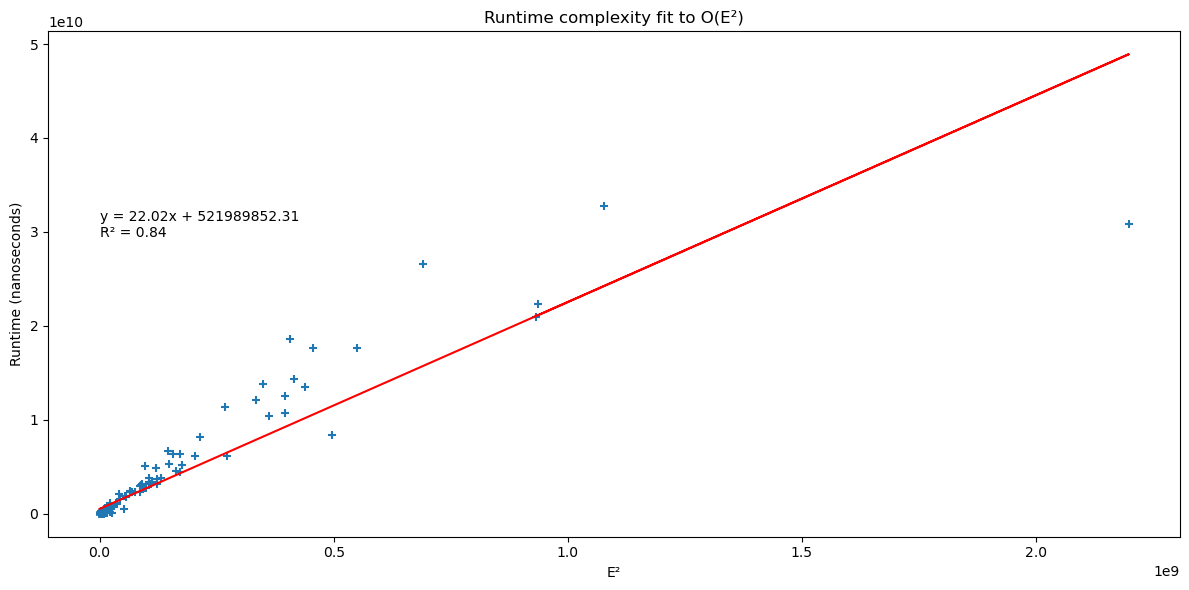

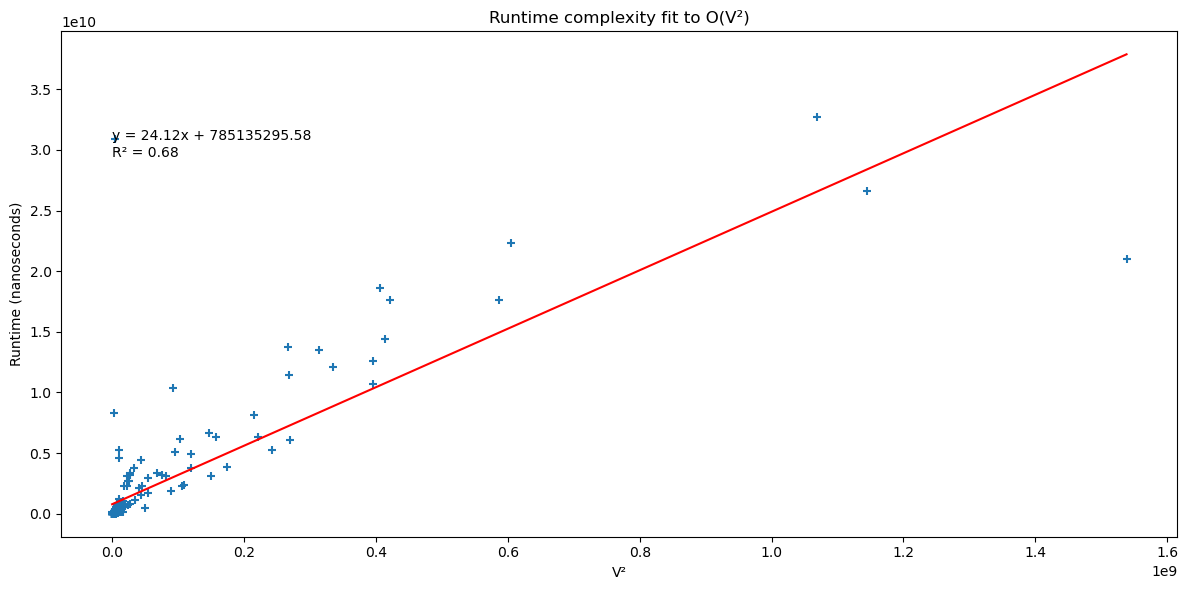

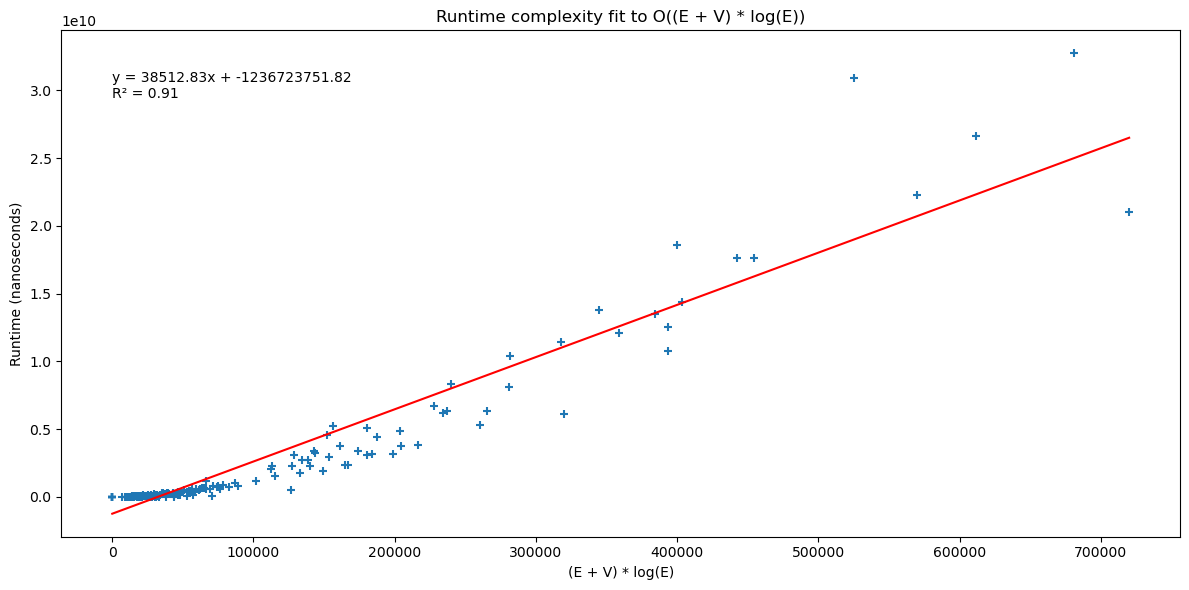

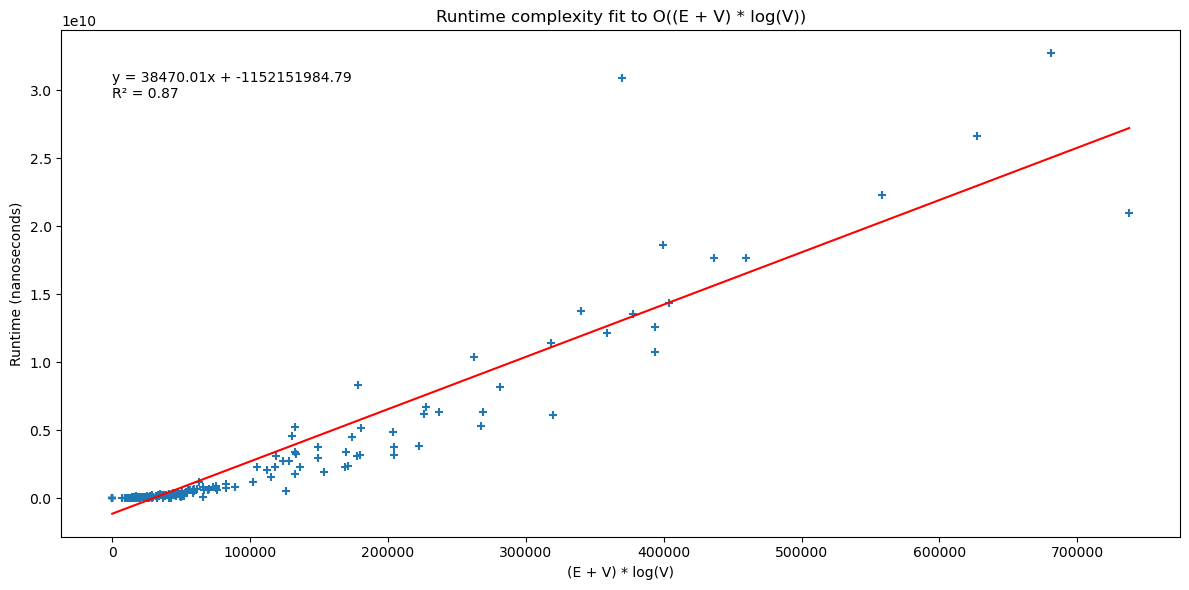

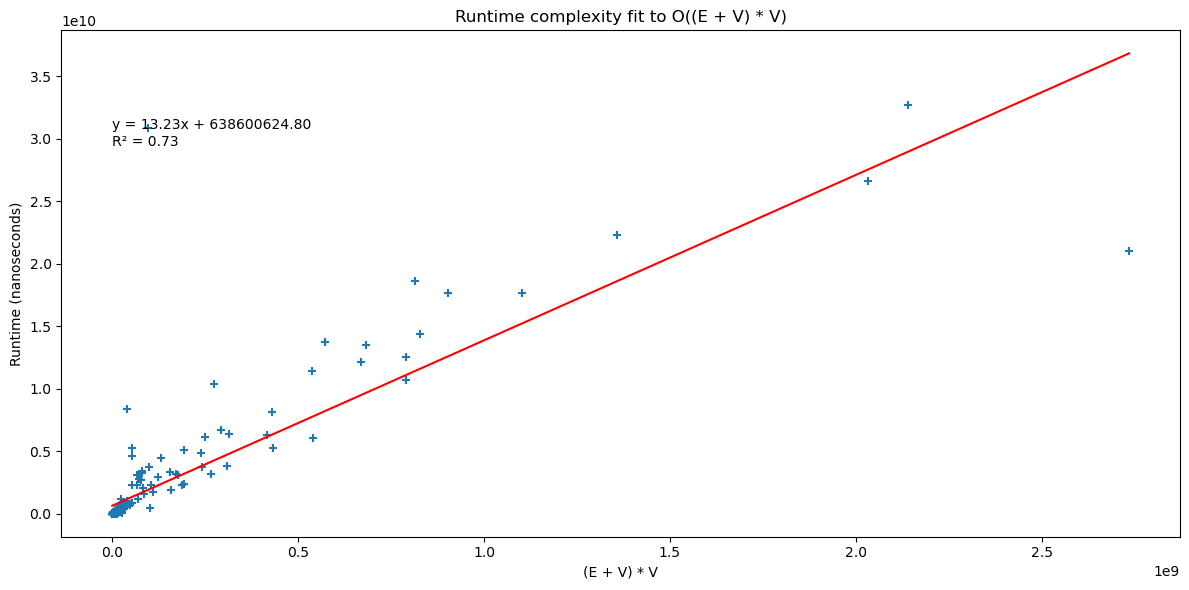

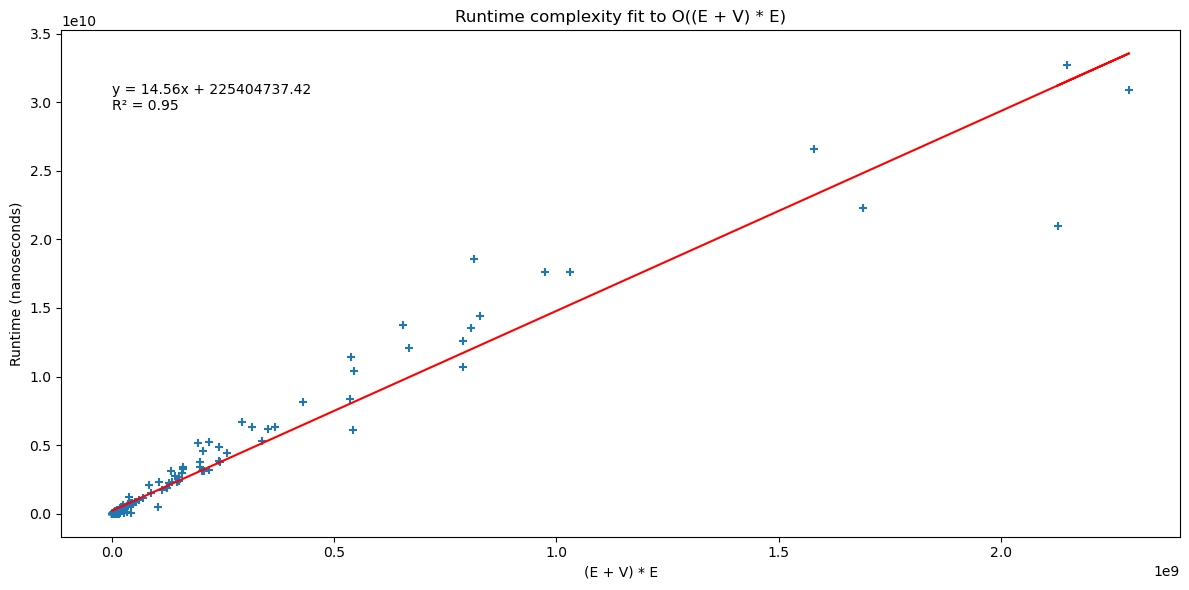

In [53]:
E = df["edge count"]
V = df["node count"]

candidates = [
    ("E", E),
    ("V", V),
    ("E²", E * E),
    ("V²", V * V),
    ("(E + V) * log(E)", (E + V) * np.log(E)),
    ("(E + V) * log(V)", (E + V) * np.log(V)),
    ("(E + V) * V", (E + V) * V),
    ("(E + V) * E", (E + V) * E),
]
for label, candidate in candidates:
    # Linear regression in order to confirm the fitting
    coeffs = np.polyfit(candidate, df["exec nanosecs"], 1)
    slope, intercept = coeffs
    r_squared = np.corrcoef(candidate, df["exec nanosecs"])[0, 1] ** 2

    # Scatter plot the data points
    plt.figure(figsize=(12, 6))
    plt.scatter(candidate, df["exec nanosecs"], marker="+")

    # Plot the linear regression line and its data
    plt.plot(candidate, slope * candidate + intercept, color="red")
    plt.text(
        candidate.min(),
        df["exec nanosecs"].max() * 0.9,
        f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.2f}",
    )

    plt.xlabel(label)
    plt.ylabel("Runtime (nanoseconds)")
    plt.title(f"Runtime complexity fit to O({label})")
    plt.tight_layout()
    plt.show()

The best fit seems to be O((E + V) * E) with a R² of 0.95, as expected from the algorithm analysis.